In [ ]:
from beartype import beartype
from beartype.typing import Optional, Tuple, Union
from scipy.spatial.distance import cdist
import numpy as np
import geopandas as gpd
from rasterio import features, profiles, transform
import geopandas as gpd
from shapely.geometry import Point

from matplotlib import pyplot as plt

In [8]:
data = {
        'random_number': [1, 2, 3, 4, 1984, 1984, 1984, 1984],
        'geometry': [Point(24.945831, 60.192059), Point(24.6559, 60.2055),
                     Point(25.0378, 60.2934), Point(24.7284, 60.2124),
                    Point(24.945831, 60.192059), Point(24.6559, 60.2055),
                     Point(25.0378, 60.2934), Point(24.7284, 60.2124)]
    }
gdf = gpd.GeoDataFrame(data)

In [9]:
resolution=(0.08910999999999999477, -0.08585219099999973069),
target_column='random_number',
power=2,
base_raster_profile = profiles.Profile(
    dict(width=9, height=7, transform=transform.from_bounds(
        24.4650089999999985, 60.5954013369999984, 25.2669989999999984, 59.9944360000000003,
        width=9, height=7))
)

In [10]:
def interpolate_vector(
    geodataframe: gpd.GeoDataFrame,
    resolution: Union[float, Tuple[float, float]],
    target_column: str,
    power: Optional[int] = 2,
    base_raster_profile: Optional[Union[profiles.Profile, dict]] = None,
    target_crs: Optional[int] = None
) -> np.ndarray:
    """
    Interpolates data from a GeoDataFrame using Inverse Distance Weighting (IDW)
        based on the given target positions.

    Args:
        geodataframe: The input vector data.
        resolution: The resolution i.e. cell size of the output raster
        power: The optional power parameter for IDW. Defaults to 2.
        target_column: The target column for interpolation.
        base_raster_profile: Base raster profile
            to be used for determining the grid on which vectors are burned in.

    Returns:
        interpolated_values: A dictionary containing the interpolated values.
    """

    # Transform geodataframe to target CRS if it is provided
    if target_crs is not None:
        geodataframe = geodataframe.to_crs(target_crs)

    if geodataframe.shape[0] == 0:
        # Empty GeoDataFrame
        raise exceptions.EmptyDataFrameException("Expected geodataframe to contain geometries.")

    if target_column is None or target_column not in geodataframe.columns:
        raise exceptions.InvalidParameterValueException(
            f"Expected target_column ({target_column}) to be contained in geodataframe columns.")

    interpolated_values = {}
    values = geodataframe[target_column].values.astype(float)

    target_positions, positions, width, height = _create_target_positions(geodataframe, resolution, base_raster_profile)
    distances = cdist(positions, target_positions)
    distances[distances == 0] = np.finfo(float).eps  # Replace zeros with a small non-zero value
    weights = 1 / distances ** power
    weights /= weights.sum(axis=0)

    interpolated_values = np.dot(weights.T, values)

    return interpolated_values


def _create_target_positions(geodataframe, resolution, base_raster_profile):
    if isinstance(resolution, tuple):
        pixel_width, pixel_height = resolution
    else:
        pixel_width = pixel_height = resolution

    if base_raster_profile is None:
        min_x, min_y, max_x, max_y = geodataframe.total_bounds
        width = int((max_x - min_x) / pixel_width)
        height = int((max_y - min_y) / pixel_height)
        out_transform = transform.from_bounds(min_x, min_y, max_x, max_y, width=width, height=height)
        target_positions = np.array(
            np.meshgrid(np.linspace(min_x, max_x, width), np.linspace(min_y, max_y, height))
        ).T.reshape(-1, 2)
    else:
        width, height, out_transform = (
            base_raster_profile["width"],
            base_raster_profile["height"],
            base_raster_profile["transform"],
        )
        min_x = out_transform[2]
        max_x = min_x + (width * out_transform[0])
        min_y = out_transform[5] + (height * out_transform[4])
        max_y = out_transform[5]
        target_positions = np.array(
            np.meshgrid(np.linspace(min_x, max_x, width), np.linspace(min_y, max_y, height))
        ).T.reshape(-1, 2)

    positions = np.array(geodataframe.geometry.apply(lambda geom: (geom.x, geom.y)).tolist())

    positions = positions.reshape(-1, 2)
    target_positions = target_positions.reshape(-1, 2)

    return target_positions, positions, width, height

In [11]:
interpolated_values = interpolate_vector(
    geodataframe = gdf,
    resolution=(0.08910999999999999477, -0.08585219099999973069),
    target_column='random_number',
    power=2,
    base_raster_profile = profiles.Profile(
        dict(width=9, height=7, transform=transform.from_bounds(
            24.4650089999999985, 60.5954013369999984, 25.2669989999999984, 59.9944360000000003,
            width=9, height=7))
    )
)
print(interpolated_values)

[1241.18562754 1242.62478171 1240.58715729 1232.88461531 1226.98023593
 1231.42071651 1236.38539863 1242.83692044 1246.90910217 1246.66305195
 1226.09054791 1198.67588904 1226.56463456 1239.61545537 1242.77065353
 1250.99619093 1263.70546976 1263.91978288 1133.20896334 1251.63216969
 1248.40676051 1238.57376532 1246.58053419 1266.98553209 1334.59347004
 1422.05180876 1288.23314968 1244.79128167 1230.72507634 1231.64403746
 1230.79255722 1215.3673155  1165.73014763 1189.41243128 1208.98566614
 1223.51820339 1220.52191539 1215.3440771  1194.45647028 1062.48232896
 1128.31047963 1179.00529227 1219.28422596 1217.40676509 1221.02265173
 1235.2122488  1176.31551376 1158.65301375 1177.98559535 1216.88644716
 1215.25082434 1215.28054454 1212.62250041 1195.56967523 1183.86914464
 1187.34503832 1215.32948759 1213.2590158  1210.93152002 1206.72608048
 1199.81119754 1194.8544739  1195.22960756]


TypeError: float() argument must be a string or a real number, not 'Point'

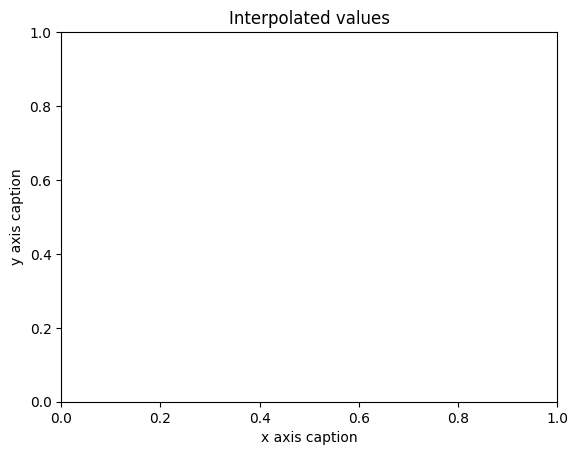

In [31]:
plt.title("Interpolated values") 
plt.xlabel("x axis caption") 
plt.ylabel("y axis caption") 
plt.plot(gdf) 
plt.show()